In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [3]:
def readData(path):
  with open(path) as f:
        captions = f.read()
  return captions

In [4]:
captions  = readData("/content/drive/MyDrive/Data_Image_Caption/textData/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]
print(len(captions))

40460


In [5]:
p1,p2  = captions[0].split('\t')
print(p1.split(".")[0])
print(p2)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [6]:
dataDict = {}

for x in captions:
    p1, p2= x.split('\t')
    imgName = p1.split(".")[0]
    
    if dataDict.get(imgName) is None:
        dataDict[imgName] = []
    
    dataDict[imgName].append(p2)

In [7]:
dataDict["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

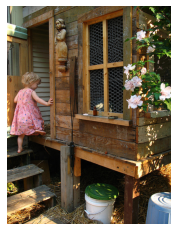

In [8]:
IMG_PATH = "/content/drive/MyDrive/Data_Image_Caption/Images/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

In [9]:
def cleanText(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [10]:
cleanText("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [11]:
for key,caption_list in dataDict.items():
    for i in range(len(caption_list)):
        caption_list[i] = cleanText(caption_list[i])

In [12]:
with open("data_1.txt","w") as f:
    f.write(str(dataDict))

In [13]:
descriptions = None
with open("data_1.txt",'r') as f:
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [14]:
print(type(descriptions))

<class 'dict'>


In [15]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))

Vocab Size : 8424
Total Words 373837


In [16]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>10]
total_words = [x[0] for x in sorted_freq_cnt]

8424


In [17]:
print(len(total_words))

1845


In [18]:
train_file_data = readData("/content/drive/MyDrive/Data_Image_Caption/textData/Flickr_8k.trainImages.txt")
test_file_data = readData("/content/drive/MyDrive/Data_Image_Caption/textData/Flickr_8k.testImages.txt")

In [19]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [20]:
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [21]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [22]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

102973440/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [ ]:
model_new = Model(model.input,model.layers[-2].output)

In [23]:
def imagePreprocess(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    return img

In [24]:
def imageEncoding(img):
    img = imagePreprocess(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [ ]:
imageEncoding(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.06535947, 0.16782546, 0.32517573, ..., 0.05107125, 0.32821143,
       1.004337  ], dtype=float32)

6000


In [ ]:
start = time()
encoding_train = {}

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = imageEncoding(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

In [ ]:
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [91]:
start = time()
encoding_test = {}

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = imageEncoding(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

NameError: ignored

In [92]:
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [25]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [26]:
print(len(word_to_idx))
print(len(idx_to_word))

1845
1845


In [27]:
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [28]:
maxLen = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        maxLen = max(maxLen,len(cap.split()))
        
print(maxLen)

35


In [29]:
def dataGenerator(trainDesc, encoding_train, word_to_idx, maxLen, batchSize) :
  x1 = []
  x2 = []
  y = []
  n = 0

  while True:
    for key, descList in trainDesc.items():
      n = n + 1

      photo = encoding_train[key]
      for desc in descList:
        seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
        for i in range(1, len(seq)):
          xi = seq[0:i]
          yi = seq[i]

          xi = pad_sequences([xi], maxlen = maxLen, value = 0, padding = 'post')[0]
          yi = to_categorical([yi], num_classes = vocab_size)[0]

          x1.append(photo)
          x2.append(xi)
          y.append(yi)

        if n == batchSize:
          yield [np.array(x1),np.array(x2)], np.array(y)
          x1 = []
          x2 = []
          y = []
          n = 0


In [30]:
f = open("/content/drive/MyDrive/Data_Image_Caption/glove.6B.50d.txt",encoding='utf8')

In [31]:
embedding_index = {}

for line in f:
  values = line.split()
  word = values[0]
  word_embedding = np.array(values[1:],dtype='float')
  embedding_index[word] = word_embedding

In [32]:
f.close()

In [33]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [34]:
def embeddingMatrix():
  emb_dim = 50
  matrix = np.zeros((vocab_size, emb_dim))
  for word, idx in word_to_idx.items():
    embedding_vector = embedding_index.get(word)

    if embedding_vector is not None:
      matrix[idx] = embedding_vector

  return matrix

In [35]:
embedding_matrix = embeddingMatrix()
embedding_matrix.shape

(1848, 50)

In [36]:
inputImg_features = Input(shape = (2048,))
inp1 = Dropout(0.3)(inputImg_features)
inp2 = Dense(256,activation='relu')(inp1)

In [37]:
input_captions = Input(shape=(maxLen,))
inpcap1 = Embedding(input_dim = vocab_size, output_dim = 50, mask_zero = True)(input_captions)
inpcap2 = Dropout(0.3)(inpcap1)
inpcap3 = LSTM(256)(inpcap2)

In [38]:
decoder1 = add([inp2,inpcap3])
decoder2 = Dense(256,activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)
model = Model(inputs = [inputImg_features, input_captions], outputs = outputs)

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

In [40]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [41]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [56]:
epochs = 10
batchSize = 6
steps = len(train_descriptions)//batchSize

In [43]:
import pickle
dbfile = open('/content/drive/MyDrive/Data_Image_Caption/encoded_train_features.pkl', 'rb')     
encoding_train = pickle.load(dbfile)
print(len(encoding_train))

6000


In [57]:
for i in range(epochs):
  generator = dataGenerator(train_descriptions,encoding_train, word_to_idx, maxLen, batchSize)
  model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)
  model.save('/content/model_weights/'+str(i)+'.h5')

   4/1000 [..............................] - ETA: 22s - loss: 2.4180

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


1000/1000 [==============================] - 21s 21ms/step - loss: 2.4038


In [45]:
# mymodel = load_model("/content/model_weights/9.h5")

In [58]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(maxLen):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=maxLen,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [54]:
import pickle
dbfile = open('/content/drive/MyDrive/Data_Image_Caption/encoded_test_features.pkl', 'rb')     
encoding_test = pickle.load(dbfile)
print(len(encoding_test))

1000


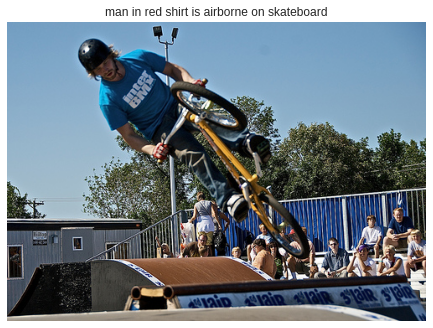

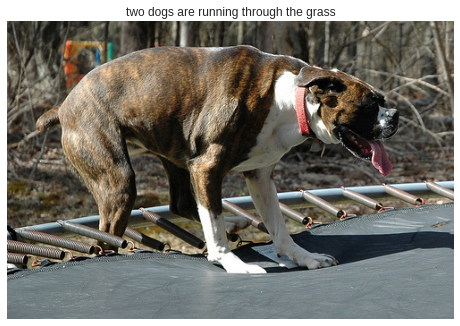

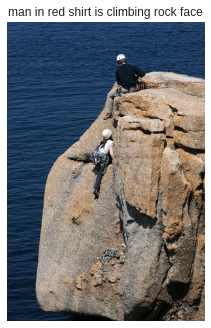

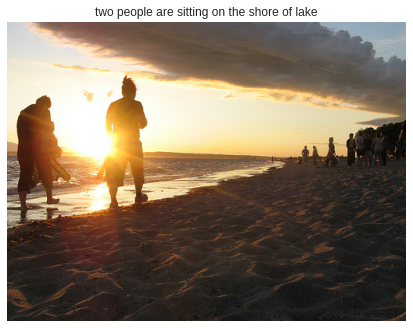

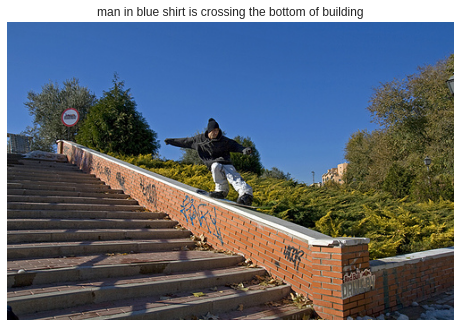

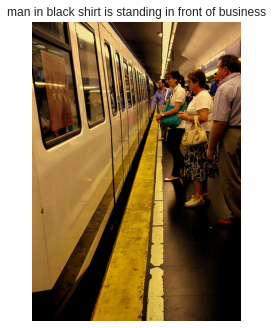

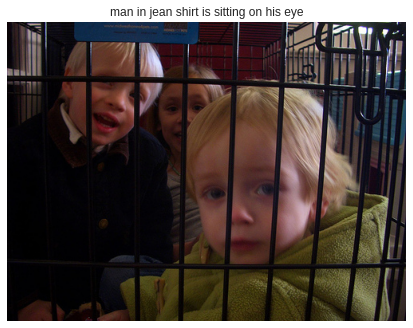

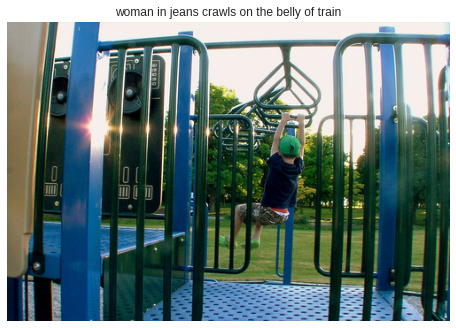

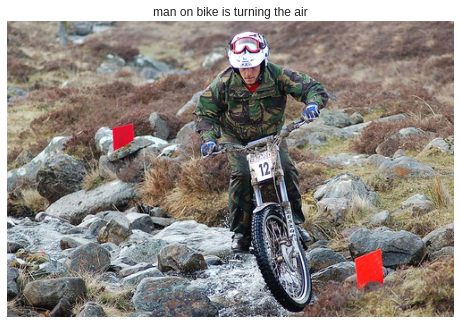

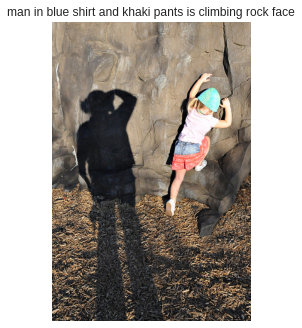

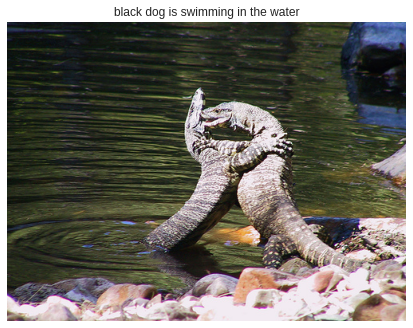

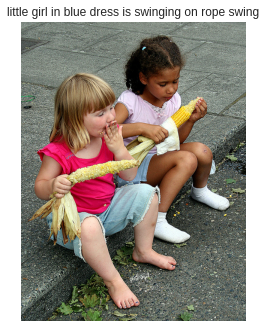

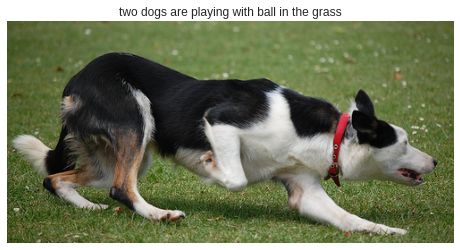

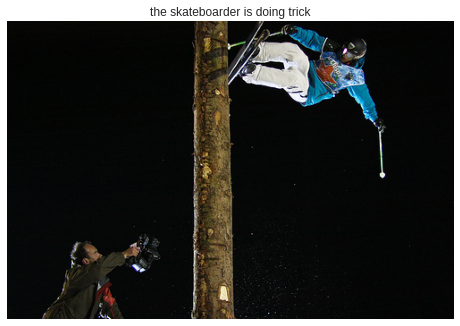

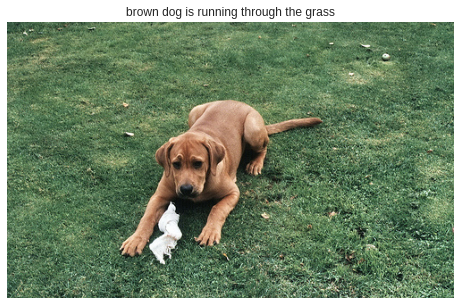

In [59]:
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("/content/drive/MyDrive/Data_Image_Caption/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()